## Importar Librerías

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import emoji
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sentiment_analysis_spanish import sentiment_analysis

from transformers import pipeline

import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [24]:
#nltk.download('all')
#uralicApi.download("spa")

## Limpieza de Datos

In [25]:
df = pd.read_csv("dbEtiquetado.csv")
df.shape

(812, 5)

In [26]:
df.head(10)

,date,time,tweet,relevance,topic
0,2023-01-01,NaN,"Resuelto, muchísimas gracias , excelente servi...",1,misc
1,2023-01-02,NaN,"Muchas gracias, espero su dm",0,misc
2,2023-01-02,NaN,Muchas gracias!,0,misc
3,2023-01-02,NaN,Algo similar me paso. Quería renovar mi token ...,1,misc
4,2023-01-02,NaN,Yeeeei! a través de mi cuenta en acabo de cont...,1,misc
5,2023-01-02,NaN,Esta es la señal que necesitan para tener el m...,1,misc
6,2023-01-03,NaN,Gracias 😁,0,misc
7,2023-01-03,NaN,Muchas gracias 😊,0,misc
8,2023-01-03,NaN,"Yo no sé mucho, pero te recomiendo la Inversió...",1,misc
9,2023-01-04,NaN,Gracias por la playera que me dieron en Galerí...,1,misc


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       812 non-null    object
 1   time       424 non-null    object
 2   tweet      812 non-null    object
 3   relevance  812 non-null    int64 
 4   topic      812 non-null    object
dtypes: int64(1), object(4)
memory usage: 31.8+ KB


In [28]:
df["Palabras"] = [len(msg.split()) for msg in df["tweet"]]

In [29]:
df.head(10)

,date,time,tweet,relevance,topic,Palabras
0,2023-01-01,NaN,"Resuelto, muchísimas gracias , excelente servi...",1,misc,8
1,2023-01-02,NaN,"Muchas gracias, espero su dm",0,misc,5
2,2023-01-02,NaN,Muchas gracias!,0,misc,2
3,2023-01-02,NaN,Algo similar me paso. Quería renovar mi token ...,1,misc,28
4,2023-01-02,NaN,Yeeeei! a través de mi cuenta en acabo de cont...,1,misc,47
5,2023-01-02,NaN,Esta es la señal que necesitan para tener el m...,1,misc,13
6,2023-01-03,NaN,Gracias 😁,0,misc,2
7,2023-01-03,NaN,Muchas gracias 😊,0,misc,3
8,2023-01-03,NaN,"Yo no sé mucho, pero te recomiendo la Inversió...",1,misc,36
9,2023-01-04,NaN,Gracias por la playera que me dieron en Galerí...,1,misc,10


### Algunas Gráficas Iniciales

C:\Users\juanj\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


[Text(0.5, 0, 'Cantidad de Palabras'), Text(0, 0.5, 'Conteo')]

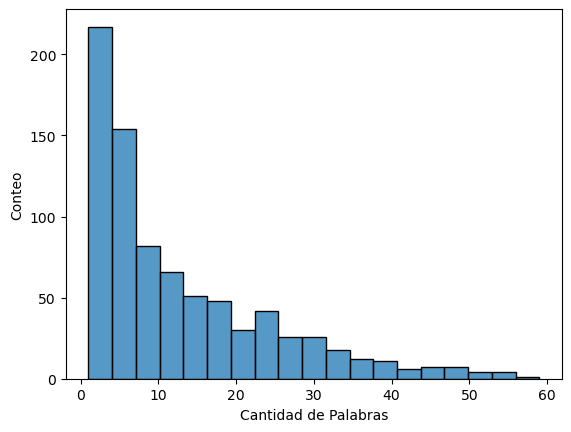

In [30]:
sns.histplot(x = "Palabras", data = df).set(xlabel='Cantidad de Palabras', ylabel='Conteo')

### Desemojizar

In [31]:
for i in range(len(df)):
    df.loc[i,'tweet'] = emoji.demojize(df.loc[i,'tweet'], language='es')

## Sentiment Analysis

In [32]:
# Función para preprocesar el texto
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('spanish')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    
    
    # ----------- LIMPIAR CARACTERES Y PALABRAS ----------------
    processed_text = processed_text.replace(',', '')
    processed_text = processed_text.replace('.', '')
    processed_text = processed_text.replace(':', '')
    processed_text = processed_text.replace(',', '')
    processed_text = processed_text.replace('!', '')
    processed_text = processed_text.replace('¡', '')
    #processed_text = processed_text.replace('gracias', '')
    #processed_text = processed_text.replace('muchas', '')
    
    #processed_text = processed_text.replace('_', ' ')
    #processed_text = processed_text.replace('cara', '')
    

    return processed_text

In [33]:
df['procTweet'] = df['tweet'].apply(preprocess_text)
# Eliminar las filas con texto vacío
df = df.loc[df['procTweet'] != '', :]
df

,date,time,tweet,relevance,topic,Palabras,procTweet
0,2023-01-01,NaN,"Resuelto, muchísimas gracias , excelente servi...",1,misc,8,resuelto muchísimas gracias excelente servic...
1,2023-01-02,NaN,"Muchas gracias, espero su dm",0,misc,5,muchas gracias espero dm
2,2023-01-02,NaN,Muchas gracias!,0,misc,2,muchas gracias
3,2023-01-02,NaN,Algo similar me paso. Quería renovar mi token ...,1,misc,28,similar paso quería renovar token poder hacer...
4,2023-01-02,NaN,Yeeeei! a través de mi cuenta en acabo de cont...,1,misc,47,yeeeei través cuenta acabo contratar cuenta a...
...,...,...,...,...,...,...,...
807,2024-04-21,15:21:43,"Ahora confirmo, gracias estimado",0,misc,4,ahora confirmo gracias estimado
808,2024-04-23,22:52:05,:cara_desanimada: de acuerdo!! Muchas gracias.,0,misc,5,cara_desanimada acuerdo muchas gracias
809,2024-04-23,21:30:12,"Tío cuando me van a graduar, tengo la TDC gara...",1,support,32,tío van graduar tdc garantizada hace año saqu...
810,2024-04-25,00:51:24,"una duda, con quién tengo que ver si tengo pro...",1,support,38,duda quién ver si problemas aumentar línea cr...


In [34]:
classifier = pipeline('sentiment-analysis', 
                      model="nlptown/bert-base-multilingual-uncased-sentiment")

results = classifier(list(df['procTweet']))

#for i in range(len(results)):
#    print(df.loc[i, 'reviewText'])
#    print(f"polaridad: {results[i]['label']}, score: {round(results[i]['score'], 4)}")
    
results = [int(result['label'].split()[0]) for result in results]
df['Rating'] = results
df

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


,date,time,tweet,relevance,topic,Palabras,procTweet,Rating
0,2023-01-01,NaN,"Resuelto, muchísimas gracias , excelente servi...",1,misc,8,resuelto muchísimas gracias excelente servic...,5
1,2023-01-02,NaN,"Muchas gracias, espero su dm",0,misc,5,muchas gracias espero dm,5
2,2023-01-02,NaN,Muchas gracias!,0,misc,2,muchas gracias,5
3,2023-01-02,NaN,Algo similar me paso. Quería renovar mi token ...,1,misc,28,similar paso quería renovar token poder hacer...,1
4,2023-01-02,NaN,Yeeeei! a través de mi cuenta en acabo de cont...,1,misc,47,yeeeei través cuenta acabo contratar cuenta a...,1
...,...,...,...,...,...,...,...,...
807,2024-04-21,15:21:43,"Ahora confirmo, gracias estimado",0,misc,4,ahora confirmo gracias estimado,5
808,2024-04-23,22:52:05,:cara_desanimada: de acuerdo!! Muchas gracias.,0,misc,5,cara_desanimada acuerdo muchas gracias,5
809,2024-04-23,21:30:12,"Tío cuando me van a graduar, tengo la TDC gara...",1,support,32,tío van graduar tdc garantizada hace año saqu...,5
810,2024-04-25,00:51:24,"una duda, con quién tengo que ver si tengo pro...",1,support,38,duda quién ver si problemas aumentar línea cr...,1


In [35]:
dfBackup = df

In [46]:
df = dfBackup
df.reset_index(inplace=True, drop=True)
df

,date,time,tweet,relevance,topic,Palabras,procTweet,Rating
0,2023-01-01 00:00:00,NaN,"Resuelto, muchísimas gracias , excelente servi...",1,misc,8,resuelto muchísimas gracias excelente servic...,5
1,2023-01-02 00:00:00,NaN,"Muchas gracias, espero su dm",0,misc,5,muchas gracias espero dm,5
2,2023-01-02 00:00:00,NaN,Muchas gracias!,0,misc,2,muchas gracias,5
3,2023-01-02 00:00:00,NaN,Algo similar me paso. Quería renovar mi token ...,1,misc,28,similar paso quería renovar token poder hacer...,1
4,2023-01-02 00:00:00,NaN,Yeeeei! a través de mi cuenta en acabo de cont...,1,misc,47,yeeeei través cuenta acabo contratar cuenta a...,1
...,...,...,...,...,...,...,...,...
806,2024-04-21,15:21:43,"Ahora confirmo, gracias estimado",0,misc,4,ahora confirmo gracias estimado,5
807,2024-04-23,22:52:05,:cara_desanimada: de acuerdo!! Muchas gracias.,0,misc,5,cara_desanimada acuerdo muchas gracias,5
808,2024-04-23,21:30:12,"Tío cuando me van a graduar, tengo la TDC gara...",1,support,32,tío van graduar tdc garantizada hace año saqu...,5
809,2024-04-25,00:51:24,"una duda, con quién tengo que ver si tengo pro...",1,support,38,duda quién ver si problemas aumentar línea cr...,1


### Fechas y Otras Cosas

In [47]:
for i in range(len(df['date'])):
    df.loc[i, 'date'] = pd.to_datetime(df.loc[i, 'date'], format='%Y-%m-%d')

df.drop('time', axis = 1, inplace = True)
df

,date,tweet,relevance,topic,Palabras,procTweet,Rating
0,2023-01-01 00:00:00,"Resuelto, muchísimas gracias , excelente servi...",1,misc,8,resuelto muchísimas gracias excelente servic...,5
1,2023-01-02 00:00:00,"Muchas gracias, espero su dm",0,misc,5,muchas gracias espero dm,5
2,2023-01-02 00:00:00,Muchas gracias!,0,misc,2,muchas gracias,5
3,2023-01-02 00:00:00,Algo similar me paso. Quería renovar mi token ...,1,misc,28,similar paso quería renovar token poder hacer...,1
4,2023-01-02 00:00:00,Yeeeei! a través de mi cuenta en acabo de cont...,1,misc,47,yeeeei través cuenta acabo contratar cuenta a...,1
...,...,...,...,...,...,...,...
806,2024-04-21 00:00:00,"Ahora confirmo, gracias estimado",0,misc,4,ahora confirmo gracias estimado,5
807,2024-04-23 00:00:00,:cara_desanimada: de acuerdo!! Muchas gracias.,0,misc,5,cara_desanimada acuerdo muchas gracias,5
808,2024-04-23 00:00:00,"Tío cuando me van a graduar, tengo la TDC gara...",1,support,32,tío van graduar tdc garantizada hace año saqu...,5
809,2024-04-25 00:00:00,"una duda, con quién tengo que ver si tengo pro...",1,support,38,duda quién ver si problemas aumentar línea cr...,1


In [48]:
for i in range(len(df['Rating'])):
    if df.loc[i, 'Rating'] > 3:
        df.loc[i, 'Sentimiento'] = 1
    else:
        df.loc[i, 'Sentimiento'] = 0
df

,date,tweet,relevance,topic,Palabras,procTweet,Rating,Sentimiento
0,2023-01-01 00:00:00,"Resuelto, muchísimas gracias , excelente servi...",1,misc,8,resuelto muchísimas gracias excelente servic...,5,1.0
1,2023-01-02 00:00:00,"Muchas gracias, espero su dm",0,misc,5,muchas gracias espero dm,5,1.0
2,2023-01-02 00:00:00,Muchas gracias!,0,misc,2,muchas gracias,5,1.0
3,2023-01-02 00:00:00,Algo similar me paso. Quería renovar mi token ...,1,misc,28,similar paso quería renovar token poder hacer...,1,0.0
4,2023-01-02 00:00:00,Yeeeei! a través de mi cuenta en acabo de cont...,1,misc,47,yeeeei través cuenta acabo contratar cuenta a...,1,0.0
...,...,...,...,...,...,...,...,...
806,2024-04-21 00:00:00,"Ahora confirmo, gracias estimado",0,misc,4,ahora confirmo gracias estimado,5,1.0
807,2024-04-23 00:00:00,:cara_desanimada: de acuerdo!! Muchas gracias.,0,misc,5,cara_desanimada acuerdo muchas gracias,5,1.0
808,2024-04-23 00:00:00,"Tío cuando me van a graduar, tengo la TDC gara...",1,support,32,tío van graduar tdc garantizada hace año saqu...,5,1.0
809,2024-04-25 00:00:00,"una duda, con quién tengo que ver si tengo pro...",1,support,38,duda quién ver si problemas aumentar línea cr...,1,0.0


In [51]:
df.to_csv('dbProcessed.csv', index = False)